# nookbook概要：
对资金的总赎入进行简单的分解：分解为固定趋势与平稳信号部分。平稳信号部分使用ARIMMA模型进行拟合

In [1]:
#!/usr/bin/env python
# coding=utf-8
# -------- import basic package --------
%pylab inline
import pdb
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import warnings
import random
from datetime import datetime
import matplotlib.pylab as plt

from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

PATH = 'F:/codeGit/dataset/Purchase&Redemption/'
FILE_BANK = 'mfd_bank_shibor.csv'
FILE_SHARE = 'mfd_day_share_interest.csv'
FILE_USER_BALANCE = 'user_balance_table.csv'
FILE_USER_PROFILE = 'user_profile_table.csv'

Populating the interactive namespace from numpy and matplotlib


In [4]:
df_userBalan = pd.read_csv(PATH + FILE_USER_BALANCE)
df_userBalan = df_userBalan[["user_id", "report_date", "total_purchase_amt", "consume_amt", "transfer_amt"]]
df_userBalan['time'] = pd.to_datetime(df_userBalan['report_date'], format = '%Y%m%d')
df_userBalan = df_userBalan.drop(['report_date'], axis = 1)
df_userBalan['year_month'] = df_userBalan['time'].dt.strftime('%Y-%m')
df_userBalan['day'] = df_userBalan['time'].dt.day
df_userBalan.set_index(['user_id', 'year_month'])
print df_userBalan[:5]

   user_id  total_purchase_amt  consume_amt  transfer_amt       time  \
0        1                   2            0             0 2014-08-05   
1        1                   2            0             0 2014-08-08   
2        1                   2            0             0 2014-08-11   
3        1                   2            0             0 2014-08-14   
4        1                   2            0             0 2014-08-17   

  year_month  day  
0    2014-08    5  
1    2014-08    8  
2    2014-08   11  
3    2014-08   14  
4    2014-08   17  


In [5]:
temp_gp = df_userBalan.groupby(['user_id', 'year_month'])
df_mcp = DataFrame(dict(
        max_consume = temp_gp.consume_amt.max(),
        max_purchase = temp_gp.total_purchase_amt.max()
    )).reset_index()
df_mcp = df_mcp[pd.notnull(df_mcp['max_consume'])]

## 1、查看总购买与总赎回的趋势曲线：

#### 某个月的的趋势曲线：

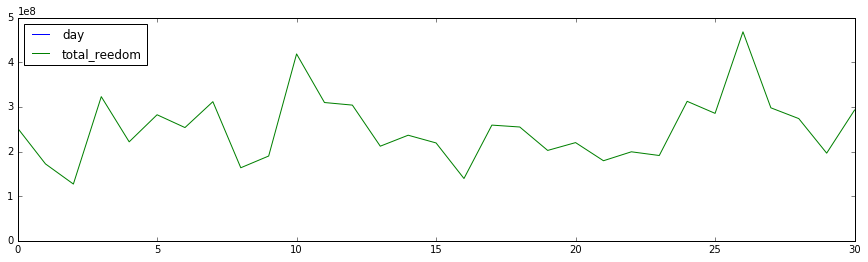

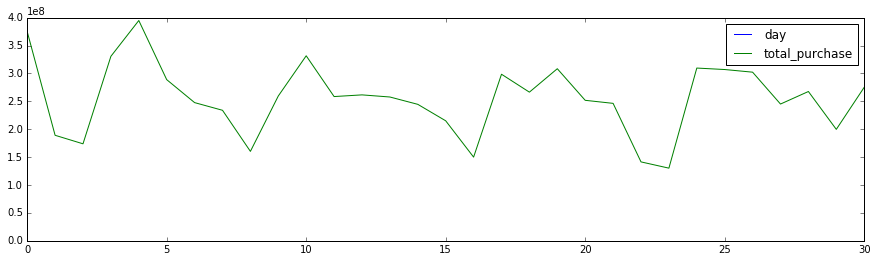

In [6]:
ymList = Series(df_mcp.year_month.unique()).order().values.tolist()
for ym in ymList:
    df_ym = df_userBalan[df_userBalan.year_month == ym]
    temp_gp = df_ym.groupby(['day'])
    df_rp = DataFrame(dict(
        total_reedom = temp_gp.consume_amt.sum() + temp_gp.transfer_amt.sum(),
        total_purchase = temp_gp.total_purchase_amt.sum(),
    )).reset_index()
    
df_rp[['day', 'total_reedom']].plot(kind='line', figsize=(15, 4))  
df_rp[['day', 'total_purchase']].plot(kind='line', figsize=(15, 4))

#### 全部十二个月的的趋势曲线：

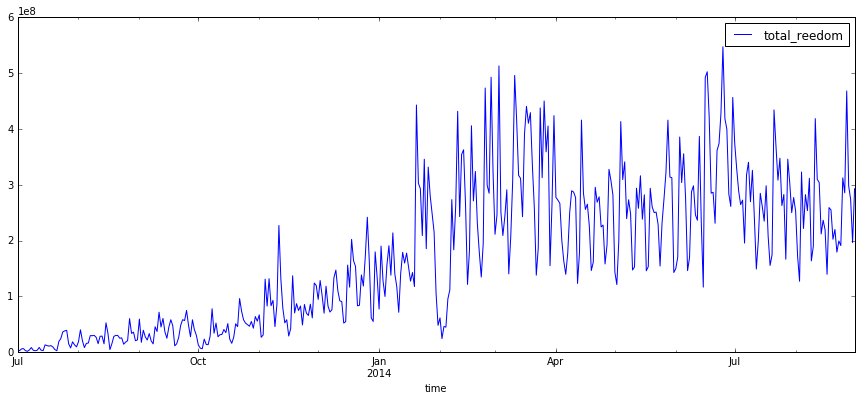

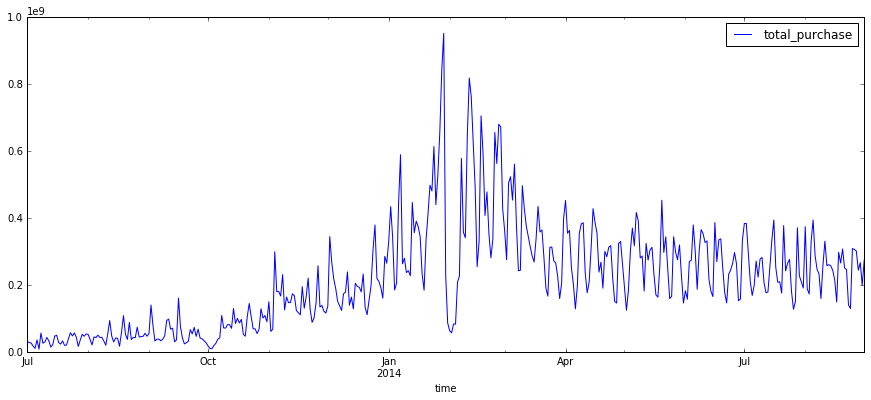

In [13]:
temp_gp = df_userBalan.groupby(['time'])
df_rp_date = DataFrame(dict(
    total_reedom = temp_gp.consume_amt.sum() + temp_gp.transfer_amt.sum(),
    total_purchase = temp_gp.total_purchase_amt.sum(),
    )).reset_index()
df_rp_date.index = df_rp_date['time']    
df_rp_date[['time', 'total_reedom']].plot(kind='line', figsize=(15, 6))  
df_rp_date[['time', 'total_purchase']].plot(kind='line', figsize=(15, 6))

In [ ]:
## 亦可使用如下的画法
plt.figure(figsize=(15,5))
plt.plot(df_rp_date.index,df_rp_date['total_reedom'])
plt.ylabel('total_reedom')
plt.title('Yearly total_reedom')

## 2、使用python的pyFlux库实现常见模型拟合

In [8]:
import pyflux as pf

In [188]:
model = pf.ARIMA(data=df_rp_date,ar=4,ma=4,integ=0,target='total_reedom')
x = model.fit("MLE")
    # 使用MLE准则去拟合模型
x.summary()

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: total_reedom                        Method: MLE                                       
Start Date: 2013-07-05 00:00:00                         Log Likelihood: -8281.7904                        
End Date: 2014-08-31 00:00:00                           AIC: 16583.5809                                   
Number of observations: 423                             BIC: 16624.0546                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 170300462. 82004454.3 2.0767   0.0378   (9571732.0894 | 331029193
AR(1)                                

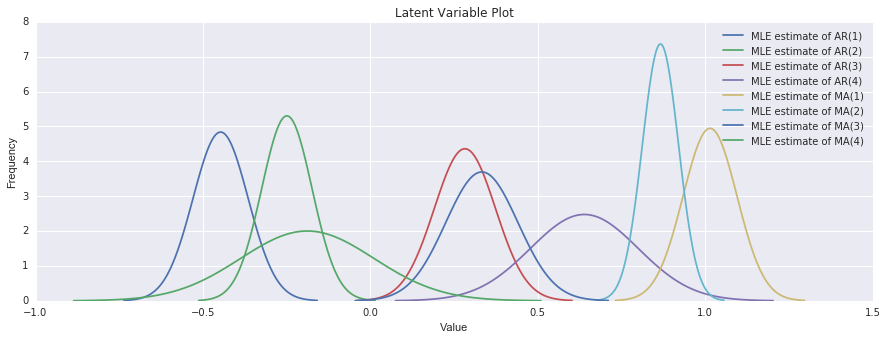

In [189]:
model.plot_z(indices=range(1,9))

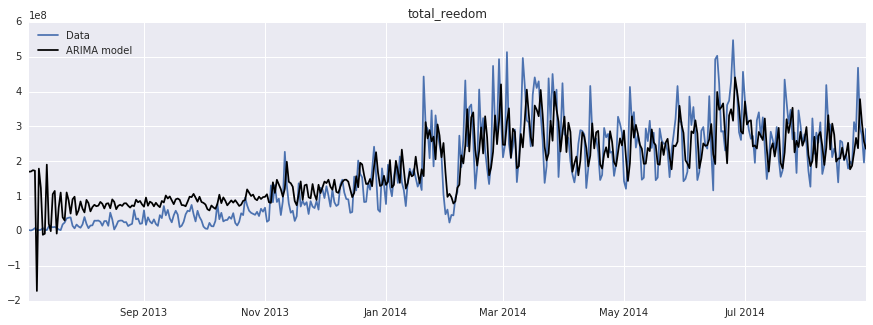

In [192]:
model.plot_fit(figsize=(15,5))

# 阶段分析：
如上所示，使用的是ARIMA模型对数据进行拟合。ARIMA模型对比AR、MA以及ARMA模型而言，其能够拟合非平稳的时序信号。
但是在上面的拟合表现中，可以明显看出前段的拟合均值偏差大，故需要对时序进行进行固定趋势的提取

## 3、使用线性回归对模型进行拟合回归，提取趋势

In [196]:
df_test = df_rp_date[df_rp_date.time >= '2014-08-01']
df_train = df_rp_date[df_rp_date.time < '2014-08-01']

### 使用简单线性回归

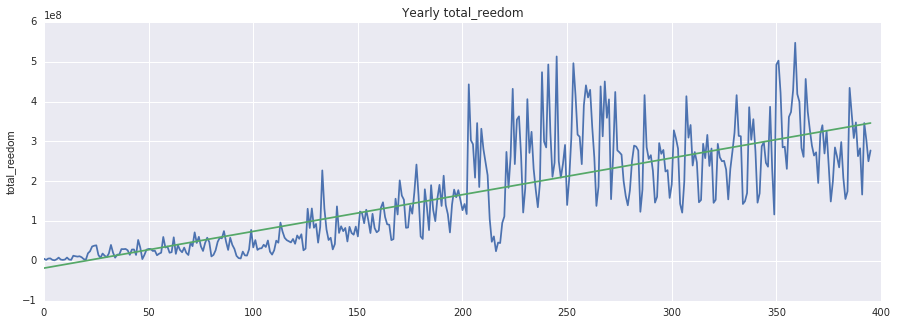

In [197]:
from sklearn.linear_model import LinearRegression 
model_trend = LinearRegression()
# model = model.fit(np.mat([1, 2]).T, np.array([1, 2]).T)
model_trend = model_trend.fit(np.mat(range(len(df_train))).T, df_train['total_reedom'].values)
preds_reed = model_trend.predict(np.mat(range(len(df_train))).T)

plt.figure(figsize=(15,5))
plt.plot(range(len(df_train)), df_train['total_reedom'])
plt.plot(range(len(df_train)), Series(preds_reed))
plt.ylabel('total_reedom')
plt.title('Yearly total_reedom')

### 使用多项式岭、核多项式岭回归

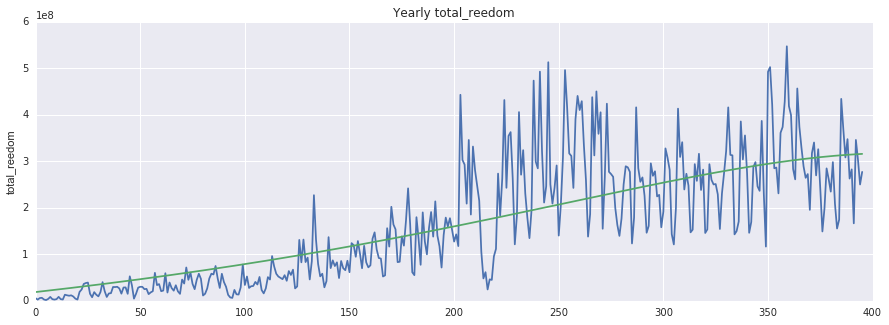

In [199]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures

model_trend = Ridge(alpha = 0.2, normalize = True)
# model = model.fit(np.mat([1, 2]).T, np.array([1, 2]).T)
X = np.mat(range(len(df_train))).T
quadratic_featurizer = PolynomialFeatures(degree=6)
X_train_quadratic = quadratic_featurizer.fit_transform(X)

model_trend = model_trend.fit(X_train_quadratic, df_train['total_reedom'].values)
preds_reed = model_trend.predict(X_train_quadratic)

plt.figure(figsize=(15,5))
plt.plot(range(len(df_train)), df_train['total_reedom'])
plt.plot(range(len(df_train)), Series(preds_reed))
plt.ylabel('total_reedom')
plt.title('Yearly total_reedom')

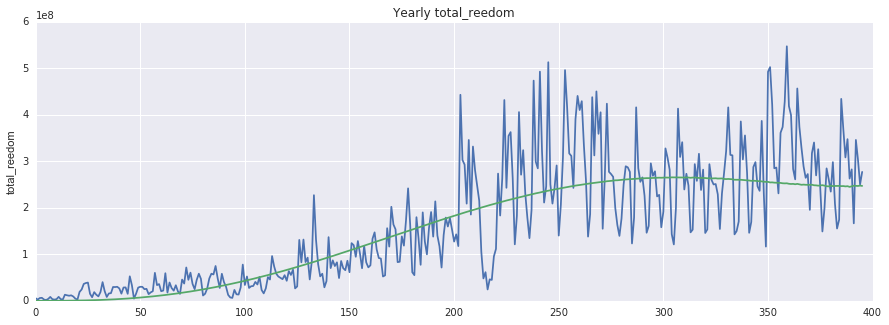

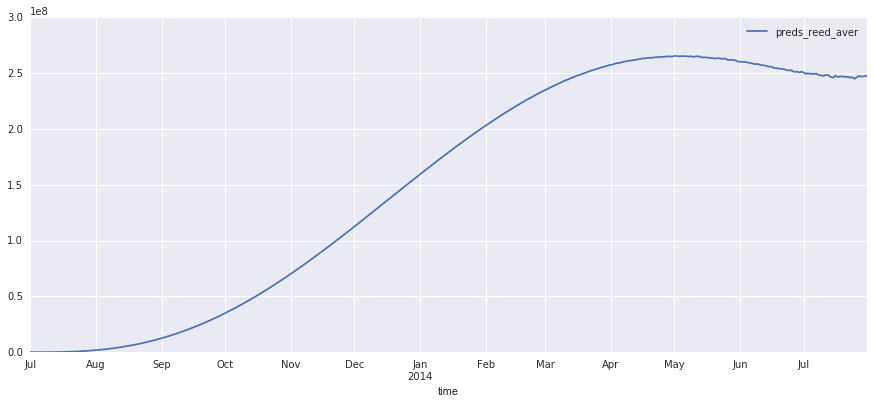

In [207]:
from sklearn.kernel_ridge import KernelRidge

model_trend = KernelRidge(alpha = 1.0)
# model = model.fit(np.mat([1, 2]).T, np.array([1, 2]).T)
X = np.mat(range(len(df_train))).T
quadratic_featurizer = PolynomialFeatures(degree=5)
X_train_quadratic = quadratic_featurizer.fit_transform(X)

model_trend = model_trend.fit(X_train_quadratic, df_train['total_reedom'].values)
preds_reed = model_trend.predict(X_train_quadratic)

plt.figure(figsize=(15,5))
plt.plot(range(len(df_train)), df_train['total_reedom'])
plt.plot(range(len(df_train)), Series(preds_reed))
plt.ylabel('total_reedom')
plt.title('Yearly total_reedom')

df_train['preds_reed_aver'] = Series(preds_reed, index = df_train.index)
df_train[['time', 'preds_reed_aver']].plot(kind='line', figsize=(15, 6))  

## 4、截取出扰动信号

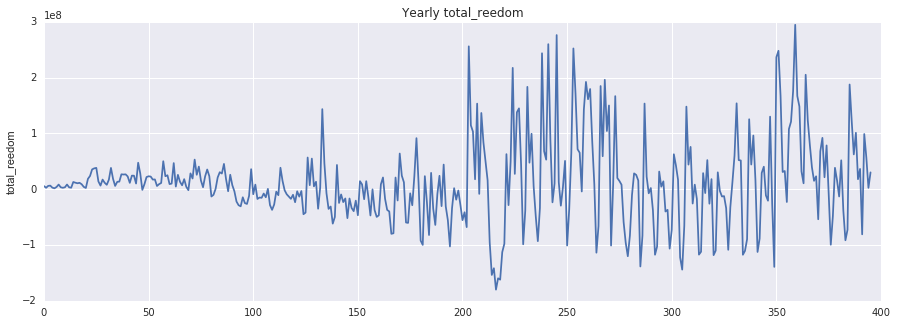

In [203]:
signal = df_train['total_reedom'].values - df_train['preds_reed_aver'].values
plt.figure(figsize=(15,5))
plt.plot(range(len(df_train)), signal)
plt.ylabel('total_reedom')
plt.title('Yearly total_reedom')

### 使用ARIMA拟合

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 4                                           Log Likelihood: -7619.3784                        
End Date: 395                                           AIC: 15258.7568                                   
Number of observations: 392                             BIC: 15298.4694                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 12085644.2 1122842.13 10.7634  0.0      (9884873.6455 | 14286414.
AR(1)                                

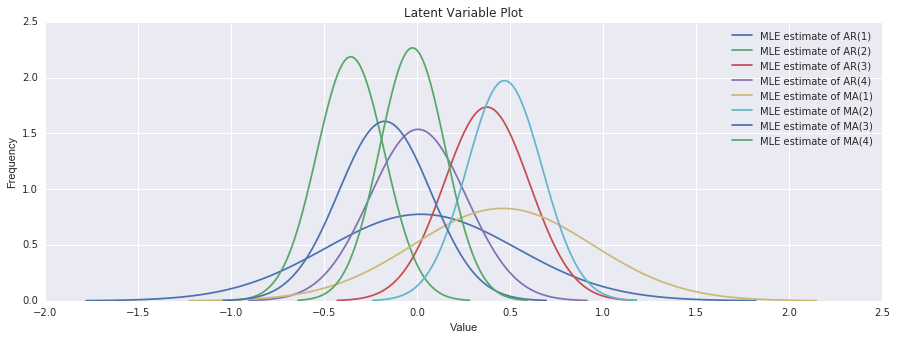

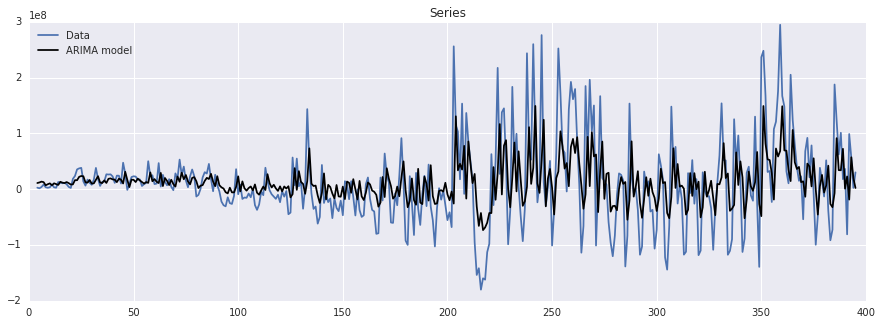

In [211]:
model_arima = pf.ARIMA(data=signal,ar=4,ma=4,integ=0)
x = model_arima.fit("MLE")
    # 使用MLE准则去拟合模型
x.summary()
model_arima.plot_z(indices=range(1,9))
model_arima.plot_fit(figsize=(15,5))

### 归一化扰动信号后，再次用ARIMA拟合
#### 使用0-1归一化

265502720.0 0.000253305177597


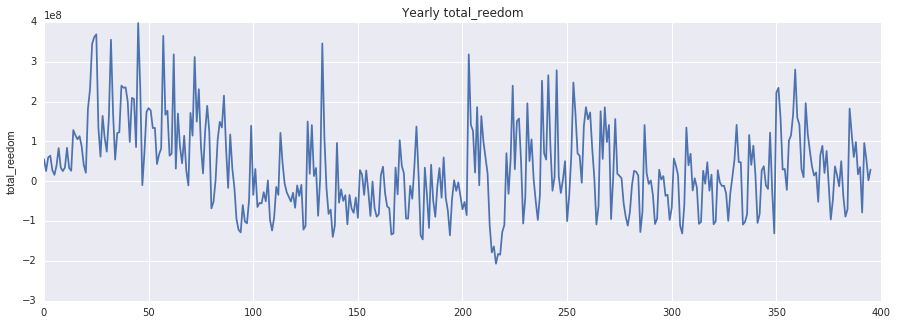

In [206]:
range_reed = Series(preds_reed).max() - Series(preds_reed).min()
min_reed = Series(preds_reed).min()
print range_reed, min_reed
preds_reed_norm = (preds_reed - min_reed) / range_reed
signal_norm = (df_train['total_reedom'].values - preds_reed) / (preds_reed_norm + 0.1)

plt.figure(figsize=(15,5))
plt.plot(range(len(df_train)), signal_norm)
plt.ylabel('total_reedom')
plt.title('Yearly total_reedom')

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 4                                           Log Likelihood: -8343.1359                        
End Date: 426                                           AIC: 16706.2719                                   
Number of observations: 423                             BIC: 16746.7456                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 23034683.0 644561.660 35.737   0.0      (21771342.2446 | 24298023
AR(1)                                

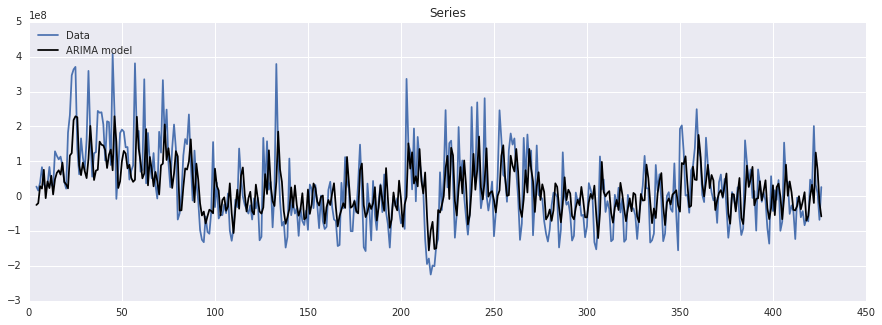

In [195]:
model_arima = pf.ARIMA(data=signal_norm,ar=4,ma=4,integ=0)
x = model.fit("MLE")
    # 使用MLE准则去拟合模型
x.summary()
model_arima.plot_fit(figsize=(15,5))

### 测试预测效果

[  2.47529472e+08   2.47988224e+08   2.48643584e+08   2.49888768e+08
   2.49364480e+08   2.48840192e+08   2.49298944e+08   2.50347520e+08
   2.50544128e+08   2.50675200e+08   2.50937344e+08   2.51985920e+08
   2.52706816e+08   2.53231104e+08   2.53362176e+08   2.54279680e+08
   2.56114688e+08   2.55852544e+08   2.58080768e+08   2.56901120e+08
   2.60177920e+08   2.59522560e+08   2.61619712e+08   2.63454720e+08
   2.63847936e+08   2.63979008e+08   2.65814016e+08   2.67780096e+08
   2.68828672e+08   2.70532608e+08   2.71450112e+08]


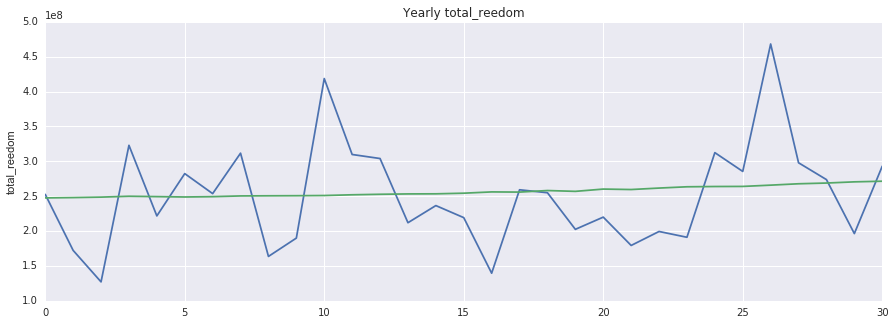

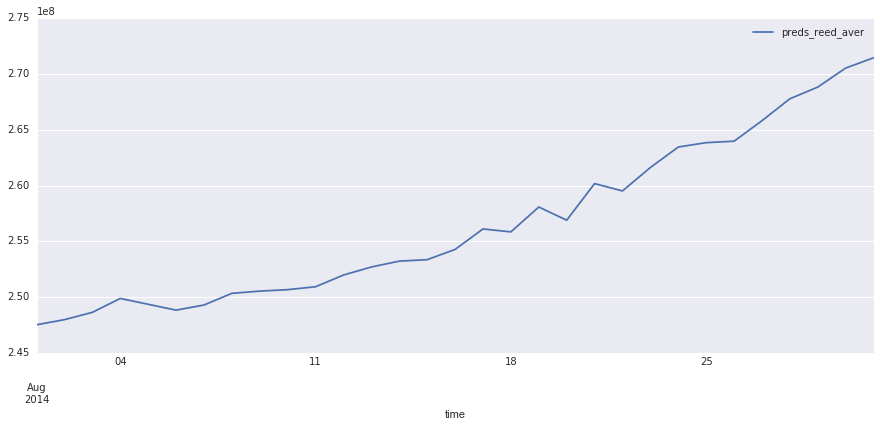

In [215]:
X = (np.mat(range(len(df_test))) + len(df_train)).T
quadratic_featurizer = PolynomialFeatures(degree=5)
X_quadratic = quadratic_featurizer.fit_transform(X)
preds_reed = model_trend.predict(X_quadratic)

plt.figure(figsize=(15,5))
plt.plot(range(len(df_test)), df_test['total_reedom'])
plt.plot(range(len(df_test)), Series(preds_reed))
plt.ylabel('total_reedom')
plt.title('Yearly total_reedom')

df_test['preds_reed_aver'] = Series(preds_reed, index = df_test.index)
df_test[['time', 'preds_reed_aver']].plot(kind='line', figsize=(15, 6))  

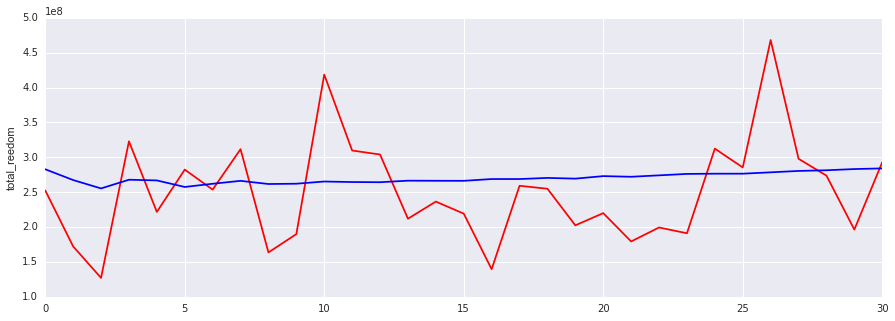

In [224]:
plt.figure(figsize=(15,5))
pred_arima = model_arima.predict(h = len(df_test))

plt.plot(range(len(df_test)), df_test['total_reedom'], color = 'r')
plt.plot(range(len(df_test)) , preds_reed + pred_arima['Series'].values.tolist(), color = 'b')
plt.ylabel('total_reedom')

# 阶段分析：
使用ARIMA的预测测试出现了平滑化的问题。但拟合图形没有问题，初步分析应该  
    1、与ARIMA的训练方法有关  
    2、或是序列的非平稳问题有关    
    3、模型的拟合图与预测图的绘图原理不一样